In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# split
from sklearn.model_selection import StratifiedShuffleSplit

# from spam
from collections import Counter

# word embedding
from gensim.models import Word2Vec
import multiprocessing
from tqdm import tqdm

# keras
from keras.preprocessing import sequence
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, GlobalMaxPooling1D, Activation, Dropout, GaussianNoise, LSTM, Bidirectional
from keras.layers import Embedding, Input, BatchNormalization, SpatialDropout1D, Conv1D, Concatenate, Flatten
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, classification_report

In [2]:
X_train = pd.read_pickle('X_train_new.pickle')
X_test = pd.read_pickle('X_test_new.pickle')

In [3]:
X_train.dropna(inplace= True)
X_test.dropna(inplace= True)

In [4]:
X_test.reset_index(inplace=True)

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_train['tokenized_text']))
list_tokenized_train = tokenizer.texts_to_sequences(X_train['tokenized_text'])
list_tokenized_test = tokenizer.texts_to_sequences(X_test['tokenized_text'])

In [12]:
pad_train = pad_sequences(list_tokenized_train, maxlen=150, padding='post')
pad_test = pad_sequences(list_tokenized_test, maxlen=150, padding='post')

In [13]:
vocab_size = len(tokenizer.word_index)+1

In [14]:
y_target = pd.get_dummies(X_train['mental_state']).values
y_target_test = pd.get_dummies(X_test['mental_state']).values

https://medium.com/@sarin.samarth07/glove-word-embeddings-with-keras-python-code-52131b0c8b1d

In [15]:
embedding_vector = {}
f = open('glove.42B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

1917495it [02:38, 12121.38it/s]


In [16]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 257265/257265 [00:00<00:00, 403961.73it/s]


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=150,trainable = False))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(3,activation = 'softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])


In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit(pad_train,y_target,epochs = 10,batch_size=256,validation_split=0.2, callbacks = [es])

Train on 1172541 samples, validate on 293136 samples
Epoch 1/10
1172541/1172541 [==============================] - 2004s 2ms/step - loss: 0.5332 - accuracy: 0.7637 - val_loss: 0.4971 - val_accuracy: 0.7795
Epoch 2/10
1172541/1172541 [==============================] - 2034s 2ms/step - loss: 0.4824 - accuracy: 0.7879 - val_loss: 0.4817 - val_accuracy: 0.7886
Epoch 3/10
1172541/1172541 [==============================] - 2065s 2ms/step - loss: 0.4663 - accuracy: 0.7952 - val_loss: 0.4751 - val_accuracy: 0.7916
Epoch 4/10
1172541/1172541 [==============================] - 2036s 2ms/step - loss: 0.4549 - accuracy: 0.8004 - val_loss: 0.4699 - val_accuracy: 0.7938
Epoch 5/10
1172541/1172541 [==============================] - 2021s 2ms/step - loss: 0.4454 - accuracy: 0.8048 - val_loss: 0.4720 - val_accuracy: 0.7942
Epoch 6/10
 600064/1172541 [==============>...............] - ETA: 14:19 - loss: 0.4355 - accuracy: 0.8093

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
model.save("model_bilstm_10_epoch.h5")

In [20]:
def performance(y_true, y_hat):
    
    y_true = list(map(lambda x: np.argmax(x), y_true))
    y_hat = list(map(lambda x: np.argmax(x), y_hat))
    
    y_true_roc = pd.DataFrame(y_true, columns = ['mental_state'])
    y_hat_roc = pd.DataFrame(y_hat, columns = ['mental_state'])
    
    y_true_roc = pd.get_dummies(y_true_roc['mental_state']).values
    y_hat_roc = pd.get_dummies(y_hat_roc['mental_state']).values
    
    # result template
    print('-'*40+' Result Report '+'-'*40)
    
    # Accuracy
    print('Accuracy: ', accuracy_score(y_true,y_hat))
    
    # Confusion matrix
    print('\n')
    print('Confusion Matrix: \n', confusion_matrix(y_true,y_hat))
    print('\n')

    # Classification Report
    print('Classification Report: \n')
    print(classification_report(y_true, y_hat))
    print('\n')
    
    # Aggregated area under the ROC curve
    print('Area under ROC curve: ', roc_auc_score(y_true_roc, y_hat_roc, multi_class='ovo'))
    
    print('-'*95)

### Result

In [21]:
predictions = model.predict(pad_test)

In [22]:
performance(y_target_test, predictions)

---------------------------------------- Result Report ----------------------------------------
Accuracy:  0.7931528532052506


Confusion Matrix: 
 [[ 95901   9374   2687]
 [  9239 133010  25876]
 [  3715  24904  61724]]


Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.89      0.88    107962
           1       0.80      0.79      0.79    168125
           2       0.68      0.68      0.68     90343

    accuracy                           0.79    366430
   macro avg       0.79      0.79      0.79    366430
weighted avg       0.79      0.79      0.79    366430



Area under ROC curve:  0.8393684766018549
-----------------------------------------------------------------------------------------------


### Plot the history result to check for overfit

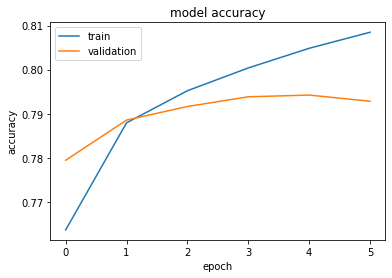

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

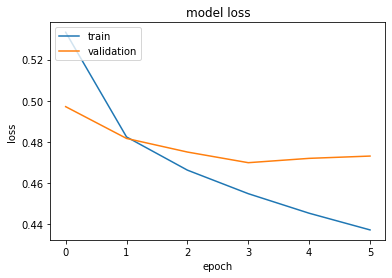

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
def check_mental_state(model, post, tokenizer):
    
    dic_state = {0:'Normal', 1:'Depressed', 2:'Suicidal'}
    
    SET_LIMIT_SENTENCE = 150
    
    print('Post: \n')
    print(post)
    print('\n')
    
    list_post = [post]
    list_post_tokenized = tokenizer.texts_to_sequences(list_post)
    post_pad = pad_sequences(list_post_tokenized, maxlen=SET_LIMIT_SENTENCE, padding='post')
    
    # classify mental state
    mental_state = model.predict(post_pad)
    
    print('Normal: ', str(round(mental_state[0][0], 2)*100)+'%')
    print('Depressed: ', str(round(mental_state[0][1], 2)*100)+'%')
    print('Suicidal: ', str(round(mental_state[0][2], 2)*100)+'%')
    
    classify_state = np.argmax(mental_state[0])
    #list(map(lambda x: np.argmax(x), mental_state))
    
    print('\n')
    print('Model Classify: ', dic_state[classify_state])

### Post Test

In [28]:
post = X_test[X_test['mental_state']==2]['tokenized_text'][19]
check_mental_state(model, post, tokenizer)

Post: 

i know i tried everything guys i gone different psychologists types anti depressants i made effort get bed every day walk my dog go gym read distant feeling increases exponentially day i never really loved life i loved people it lately spark disappeared i connect anyone fine i even connect my parents kills me inside i want stop mundane cycle my life become initially i told myself i stick it them i longer hold restrictions i always tried my best persevere keep looking forward i cried day today i realized threshold kept me taking action disappeared i want it feel selfish even thoughts somewhere i smiled loved i feel outcome inevitable please help


Normal:  0.0%
Depressed:  68.00000071525574%
Suicidal:  31.999999284744263%


Model Classify:  Depressed


In [29]:
post = X_test[X_test['mental_state']==0]['tokenized_text'][2]
check_mental_state(model, post, tokenizer)

Post: 

cc room get enough love time day come play some music hang cc room great way find new music chatting lovely people we got people room we would love come party us follow link https hit headphones sidebar go room you need sign you account already it quick easy


Normal:  100.0%
Depressed:  0.0%
Suicidal:  0.0%


Model Classify:  Normal


In [ ]:
post = X_test['tokenized_text'][36642]
check_mental_state(model, post, tokenizer)